# **NYC-Trip-Duration EDA**

##### By Mostafa Mohamed

### Table of Contents :

- [Step 1: Basic Data Inspection](#step-1:-basic-data-inspection)
   - [Import Liberaries](#import-liberaries)
   - [Read Data](#read-data)
   - [Summary Statistics For Numerical Columns](#summary-statistics-for-numerical-columns)
- [Step 2: Missing Values Analysis](#Step-2:-Missing-Values-Analysis)

- [Step 3: Data Types and Duplicate Records](#Step-3:-Data-Types-and-Duplicate-Records)
- [Step 4: Univariate Analysis](#Step-4:-Univariate-Analysis)
  - [Trip Duration](#trip-duration)
  - [Log Transformation of the Target Variable](#Log-Transformation-of-the-Target-Variable)
  - [Visualize Numerical Features](#Visualize-Numerical-Features)

- [Step 5: Feature Engineering](#Step-5:-Feature-Engineering)
  - [Geospatial Distance and Direction](#Geospatial-Distance-and-Direction)
  - [Spatial Clustering of Pickup and Dropoff Locations](#Spatial-Clustering-of-Pickup-and-Dropoff-Locations)

- [Step 6:Preparing Our DateDatetime features](#Step-6:Preparing-Our-DateDatetime-features)

- [Step 7: Extract Other Features](#Step-7:-Extract-Other-Features)

- [Step 8: Cyclical Time Encoding](#Step-8:-Cyclical-Time-Encoding)

- [Step 9: Correlation Analysis](#Step-9:-Correlation-Analysis)



## Step 1: Basic Data Inspection

Before diving into any analysis or modeling, it is essential to perform a basic inspection of the dataset. This step helps us understand:

- The structure of the dataset (rows, columns)
- The types of features (numerical, categorical, datetime, etc.)
- Whether there are any missing values or data quality issues
- The initial distribution of numerical features

We will start by displaying the first few records, checking the data types, and generating summary statistics.


### Import Liberaries


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from haversine import haversine
from math import radians, cos, sin, asin, sqrt
plt.rcParams['figure.figsize'] = [16, 10]

Read Data

In [142]:
train=pd.read_csv("Trip_train.csv")
val=pd.read_csv("Trip_val.csv")

df = pd.concat([train, val])

# Reset the index 
df.reset_index(drop=True, inplace=True)

In [143]:
train.shape,val.shape

((1000000, 10), (229319, 10))

In [144]:
# Display the first 5 rows to get an overview of the data
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


# Summary Statistics For Numerical Columns

In [145]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06
mean,1.534912e+00,1.664531e+00,-7.397345e+01,4.075093e+01,-7.397340e+01,4.075182e+01,9.596917e+02
std,4.987798e-01,1.314509e+00,6.178003e-02,3.354454e-02,6.164072e-02,3.634104e-02,5.263573e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399185e+01,4.073737e+01,-7.399133e+01,4.073590e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398173e+01,4.075411e+01,-7.397976e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396735e+01,4.076836e+01,-7.396303e+01,4.076982e+01,1.075000e+03
max,2.000000e+00,8.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [146]:
# Check data types, non-null counts, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229319 entries, 0 to 1229318
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1229319 non-null  object 
 1   vendor_id           1229319 non-null  int64  
 2   pickup_datetime     1229319 non-null  object 
 3   passenger_count     1229319 non-null  int64  
 4   pickup_longitude    1229319 non-null  float64
 5   pickup_latitude     1229319 non-null  float64
 6   dropoff_longitude   1229319 non-null  float64
 7   dropoff_latitude    1229319 non-null  float64
 8   store_and_fwd_flag  1229319 non-null  object 
 9   trip_duration       1229319 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 93.8+ MB


## Step 2: Missing Values Analysis

Handling missing data is a critical part of data preprocessing. Unaddressed missing values can lead to biased analyses or errors during model training. 

In this step, we will:
- Identify which columns contain missing values
- Calculate the number and percentage of missing entries per column
- Use this information later to decide whether to drop, fill, or otherwise process these missing values

This step lays the groundwork for clean and reliable data.


In [147]:
# Count missing values per column
missing_values = df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100

# Combine the counts and percentages into a single table
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

missing_summary


,Missing Values,Percentage (%)
id,0,0.0
vendor_id,0,0.0
pickup_datetime,0,0.0
passenger_count,0,0.0
pickup_longitude,0,0.0
pickup_latitude,0,0.0
dropoff_longitude,0,0.0
dropoff_latitude,0,0.0
store_and_fwd_flag,0,0.0
trip_duration,0,0.0


## Step 3: Data Types and Duplicate Records

Understanding the data types of each column is crucial for selecting appropriate analysis techniques and preprocessing steps. For example, datetime columns should be converted to proper datetime objects, and categorical columns should be recognized as such.

Additionally, detecting and handling duplicate records ensures the integrity of our dataset. Duplicate rows can introduce bias or redundancy in modeling.

In this step, we will:
- Review the data types of each column
- Convert columns to appropriate types if needed (e.g., dates)
- Identify and count duplicate rows


In [148]:
# Check current data types
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [149]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


## Step 4: Univariate Analysis

Univariate analysis focuses on understanding the distribution and characteristics of individual variables. This step helps us identify:

- The shape and spread of numerical features
- Presence of outliers or skewness
- The distribution of categories for categorical features
- Any irregularities or dominant values

We will visualize numerical features using histograms and box plots, and analyze categorical variables using bar charts.


## Trip Duration

In [150]:
print(df["trip_duration"].describe(),end='\n\n') # The Summary statistics of trip duration by secound is hard to measured / understand.
# We will try to convert in minutes to make the numbers more easy to read.
trip_by_seconds = df['trip_duration'].copy()
trip_by_minutes =  trip_by_seconds / 60 # Convert seconds to minutes
trip_by_minutes = pd.DataFrame(trip_by_minutes.round().astype(int))  # Convert to integer
print('std   ', trip_by_minutes.std())
print('min   ', trip_by_minutes.min())
print('mean  ', trip_by_minutes.mean())
print('median', trip_by_minutes.median())
print('max   ', trip_by_minutes.max())

count    1.229319e+06
mean     9.596917e+02
std      5.263573e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

std    trip_duration    87.727007
dtype: float64
min    trip_duration    0
dtype: int64
mean   trip_duration    15.994689
dtype: float64
median trip_duration    11.0
dtype: float64
max    trip_duration    58771
dtype: int64


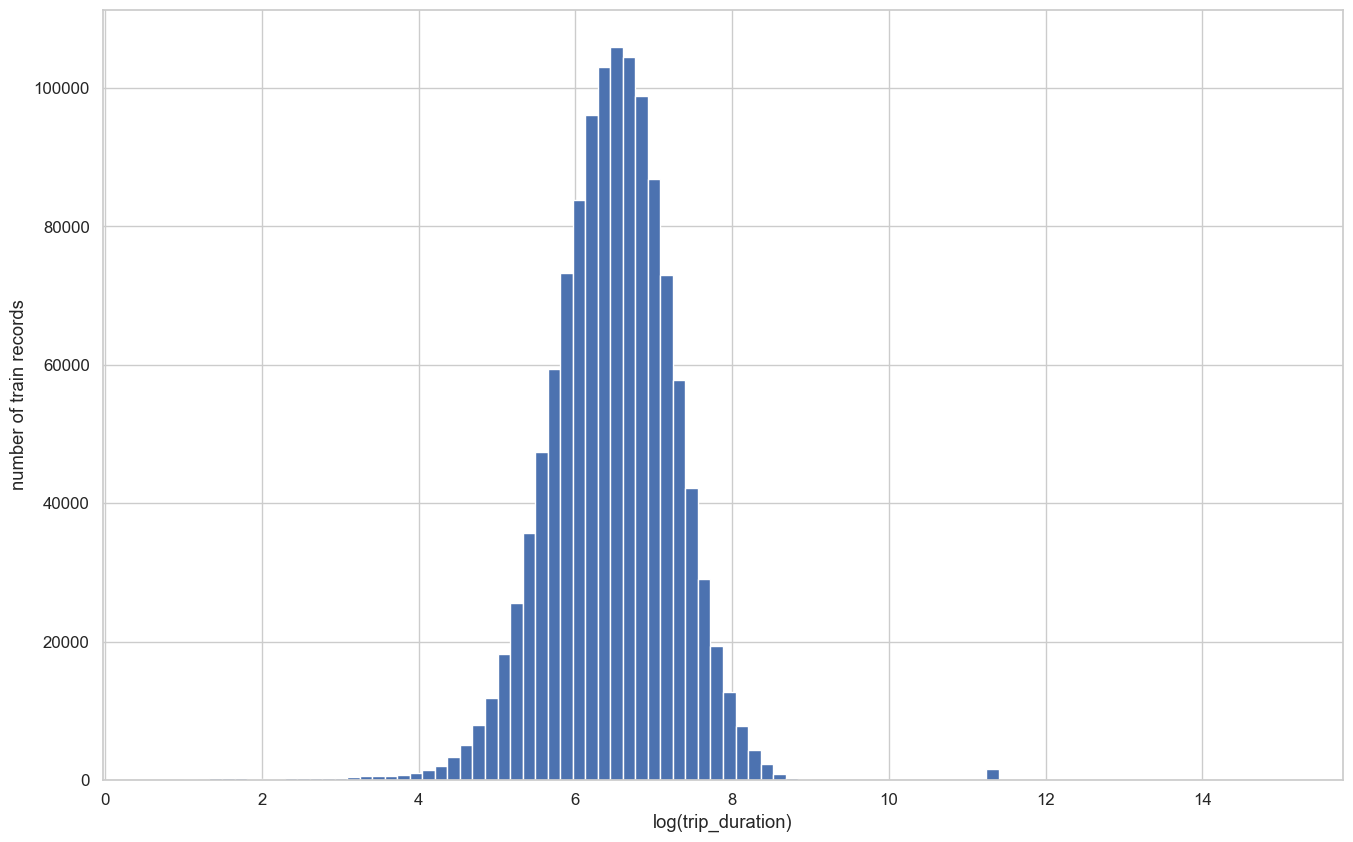

In [151]:
# 7. trip_duration
df["trip_Log_Transformed"] = np.log1p(df['trip_duration'].values)
plt.hist(df["trip_Log_Transformed"].values, bins=90)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()


### Log Transformation of the Target Variable

The `trip_duration` variable exhibits a highly skewed distribution with a long tail of very large values. This kind of skewness can make it difficult for regression models to learn effectively, as the model tends to be overly influenced by extreme values.

To address this, we applied a logarithmic transformation (`log1p`, which computes `log(1 + x)`) to the target variable. This transformation:

- Reduces the impact of outliers
- Makes the distribution more normal-like
- Helps the model learn relative differences rather than absolute magnitudes

The transformation was applied to both the training and testing sets to maintain consistency.

## Visualize Numerical Features

In [152]:
#Creating a list of all our categorical variables
cat = ["vendor_id","passenger_count"] # From before, we know that this feature can be treated like Categorical Variables
for col in cat:
    print("{} has {} unique values.".format(col,df[col].unique()))

vendor_id has [2 1] unique values.
passenger_count has [1 5 2 4 3 6 0 7 8] unique values.


## Visualize vendor_id

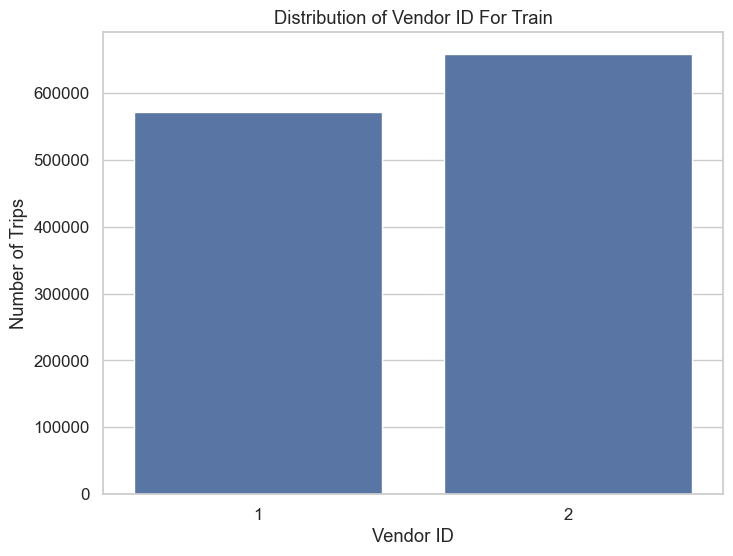

In [153]:
# 1. vendor_id
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='vendor_id')
plt.title('Distribution of Vendor ID For Train')
plt.xlabel('Vendor ID')
plt.ylabel('Number of Trips')
plt.show()

## Visualize passenger_count for train & test

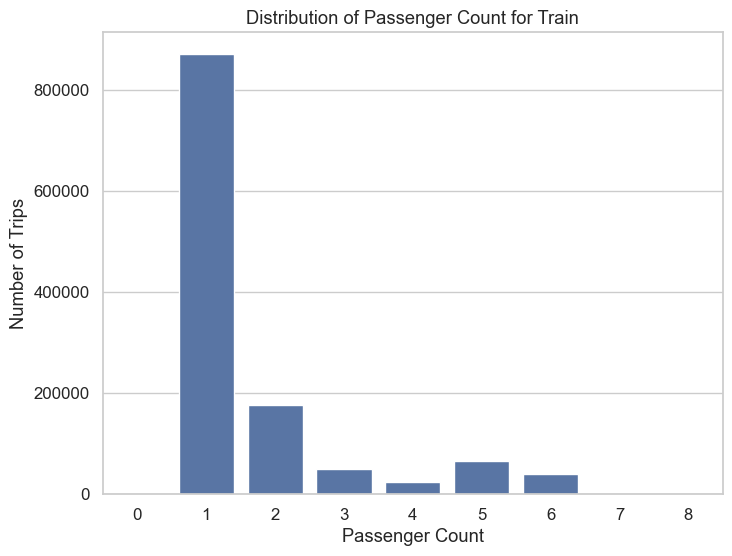

In [154]:
# 2. passenger_count
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='passenger_count')
plt.title('Distribution of Passenger Count for Train')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.show()

### Handling Outliers in `passenger_count`

Upon inspecting the distribution of the `passenger_count` feature, we observed that the vast majority of trips involved 1 to 6 passengers. However, there were a few entries with passenger counts of 0, 7, or 8, which are either invalid or extremely rare.

These outlier values could introduce noise into the model and negatively impact training and evaluation. To ensure data quality and model robustness, we removed these records from both the training and validation sets.

This filtering step helps the model focus on realistic and commonly occurring scenarios.


## pickup_longitude & pickup_latitude

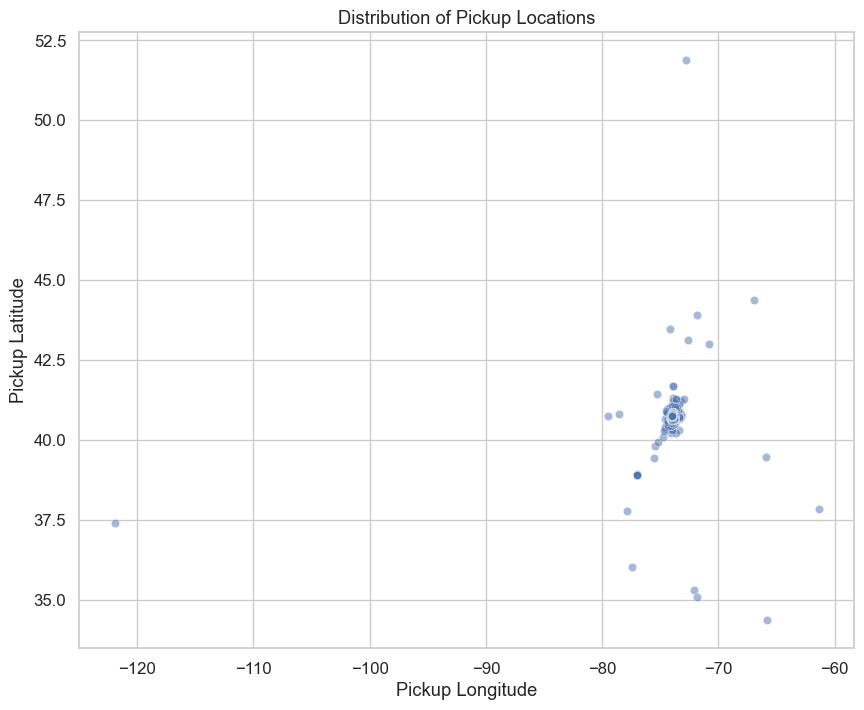

In [155]:
# 3 & 4. pickup_longitude & pickup_latitude
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train, x='pickup_longitude', y='pickup_latitude', alpha=0.5)
plt.title('Distribution of Pickup Locations')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.show()

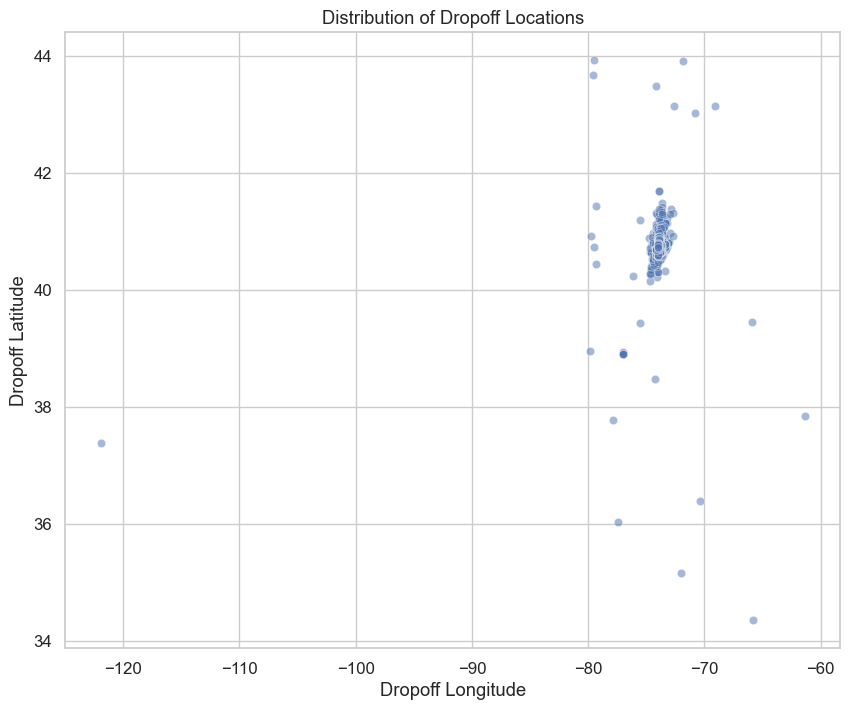

In [156]:
# 5 & 6. dropoff_longitude & dropoff_latitude
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train, x='dropoff_longitude', y='dropoff_latitude', alpha=0.5)
plt.title('Distribution of Dropoff Locations')
plt.xlabel('Dropoff Longitude')
plt.ylabel('Dropoff Latitude')
plt.show()

### Step 5: Feature Engineering

### Geospatial Distance and Direction

To enhance the predictive power of our model, we engineered several spatial features using the pickup and dropoff coordinates. These new features aim to better capture the geographical context and distance-related characteristics of each trip:

- **Haversine Distance (`distance_haversine`)**: Measures the great-circle distance between pickup and dropoff points. This is the shortest distance over the Earth's surface (in kilometers).
  
- **Dummy Manhattan Distance (`distance_dummy_manhattan`)**: An approximation of the Manhattan distance by summing the north-south and east-west components using haversine calculations.

- **Bearing (`direction`)**: Indicates the compass direction (in degrees) from the pickup point to the dropoff point. Useful for understanding trip directionality patterns.

- **Delta Features (`delta_latitude`, `delta_longitude`)**: The absolute differences between pickup and dropoff coordinates. These capture the magnitude of displacement.

- **Midpoint Coordinates (`midpoint_latitude`, `midpoint_longitude`)**: Represent the center point of each trip. Useful for spatial clustering or heatmaps.

- **Euclidean Distance (`euclidean_distance`)**: The straight-line (as-the-crow-flies) distance in degrees. Although it's not real-world accurate (due to Earth's curvature), it may still help as a proxy.

These features provide the model with rich spatial information, which is essential for estimating trip duration more accurately.


In [157]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

df.loc[:, 'distance_haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
df.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
df.loc[:, 'direction'] = bearing_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)


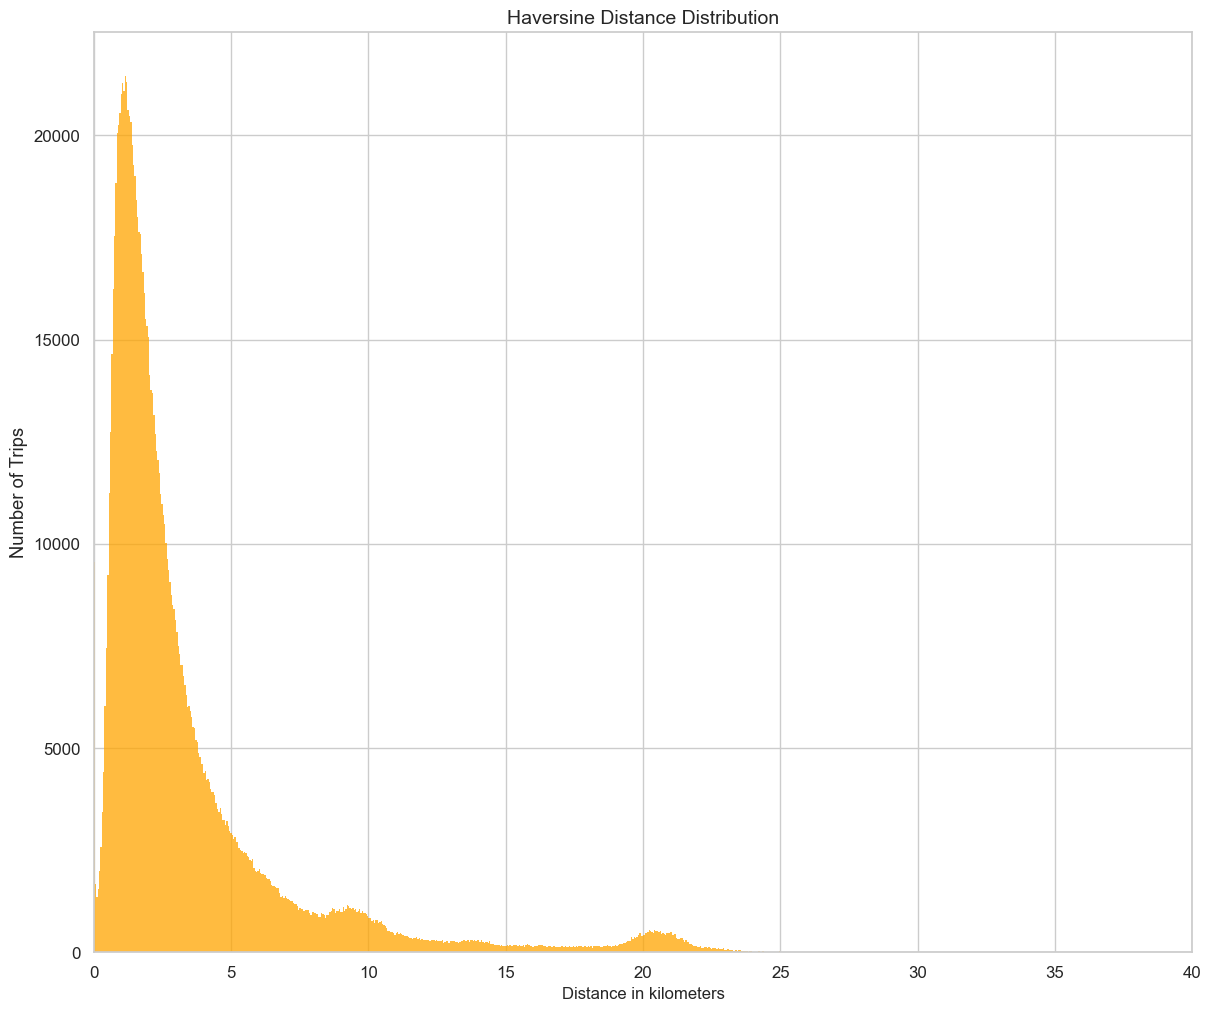

In [158]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])

sns.histplot(data=df, x='distance_haversine', color='orange', ax=ax)
ax.set_title('Haversine Distance Distribution', fontsize=14)
ax.set_xlabel('Distance in kilometers', fontsize=12)
ax.set_ylabel('Number of Trips')
plt.xlim(0, 40)

plt.show()


In [159]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_Log_Transformed,distance_haversine,distance_dummy_manhattan,direction
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,6.947937,2.763050,3.171850,9.261031
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,6.719013,1.959178,2.725608,-145.332373
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,6.421622,1.404772,1.799289,70.081271
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,6.766192,1.978660,2.056152,-2.289677
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,8.510773,20.837745,29.190178,-53.020809


### Spatial Clustering of Pickup and Dropoff Locations

To capture regional patterns in trip behavior, we applied clustering to the geographic coordinates of pickup and dropoff points using **MiniBatch K-Means**. This technique groups locations into discrete clusters that represent spatial regions within the city.

#### Key Steps:
- Combined all pickup and dropoff coordinates into a single array for joint clustering.
- Used a random subset of 5,000 points to train a **MiniBatchKMeans** model with 100 clusters for efficiency.
- Assigned each pickup and dropoff point to one of these clusters.

#### Resulting Features:
- **`pickup_cluster`**: The cluster label of the pickup location.
- **`dropoff_cluster`**: The cluster label of the dropoff location.

These features introduce regional context and allow the model to learn patterns related to specific zones or travel routes, improving its ability to generalize over space.


In [160]:
coords=np.vstack((df[['pickup_latitude','pickup_longitude']].values,
                    df[['dropoff_latitude','dropoff_longitude']].values))

In [161]:
from sklearn.cluster import MiniBatchKMeans
simple_ind=np.random.permutation(len(coords))[:5000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[simple_ind])

In [162]:
df.loc[:, 'pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']].values)
df.loc[:, 'dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']].values)

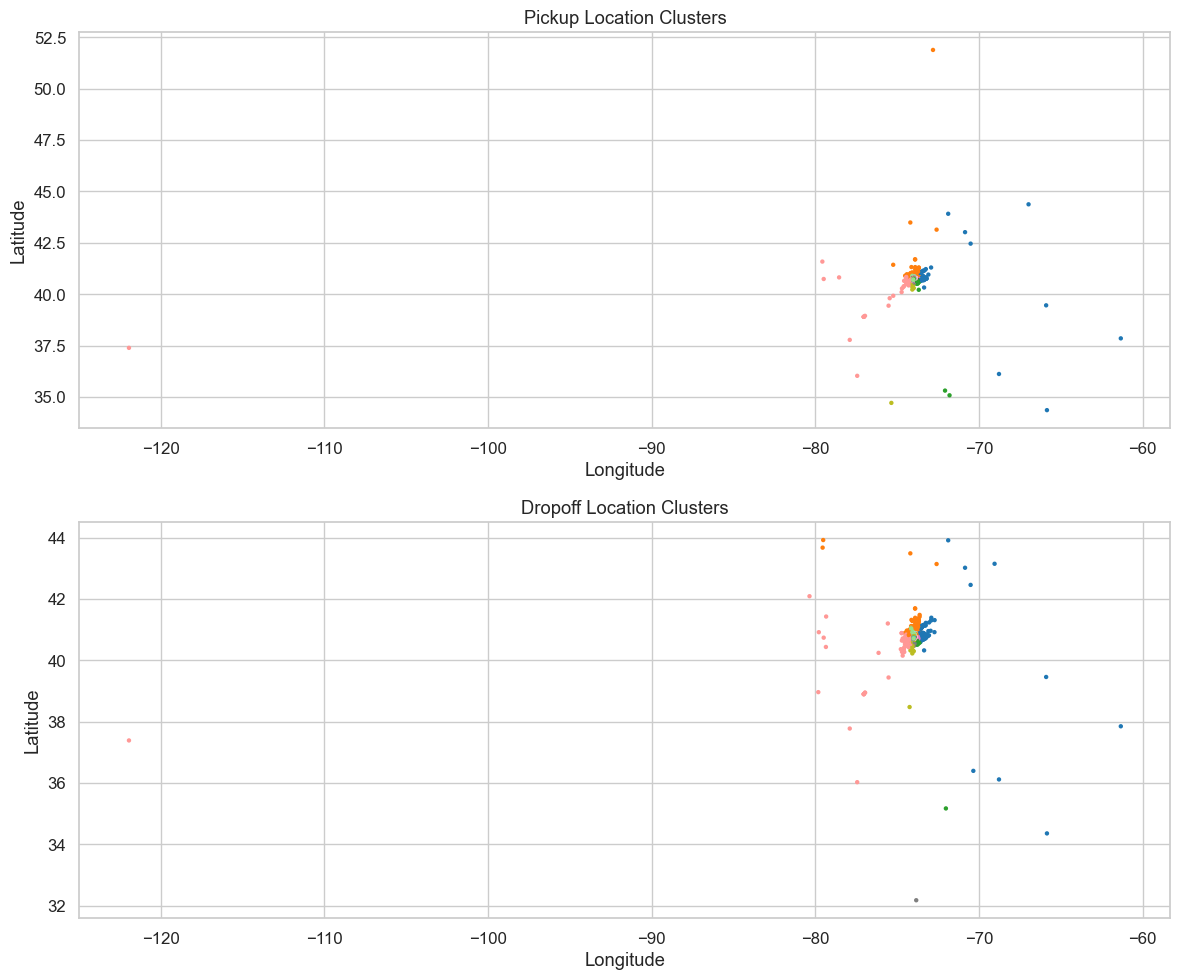

In [163]:
plt.figure(figsize=(12, 10))

# Plot pickup clusters
plt.subplot(2, 1, 1)
sns.scatterplot(
    x=df['pickup_longitude'],
    y=df['pickup_latitude'],
    hue=df['pickup_cluster'],
    palette='tab20',
    s=10,
    linewidth=0,
    legend=False
)
plt.title('Pickup Location Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot dropoff clusters
plt.subplot(2, 1, 2)
sns.scatterplot(
    x=df['dropoff_longitude'],
    y=df['dropoff_latitude'],
    hue=df['dropoff_cluster'],
    palette='tab20',
    s=10,
    linewidth=0,
    legend=False
)
plt.title('Dropoff Location Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


## Step 6:Preparing Our DateDatetime features

In [164]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dayofweek'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df['hour'] = df.pickup_datetime.dt.hour
df['dayofmonth'] = df.pickup_datetime.dt.day

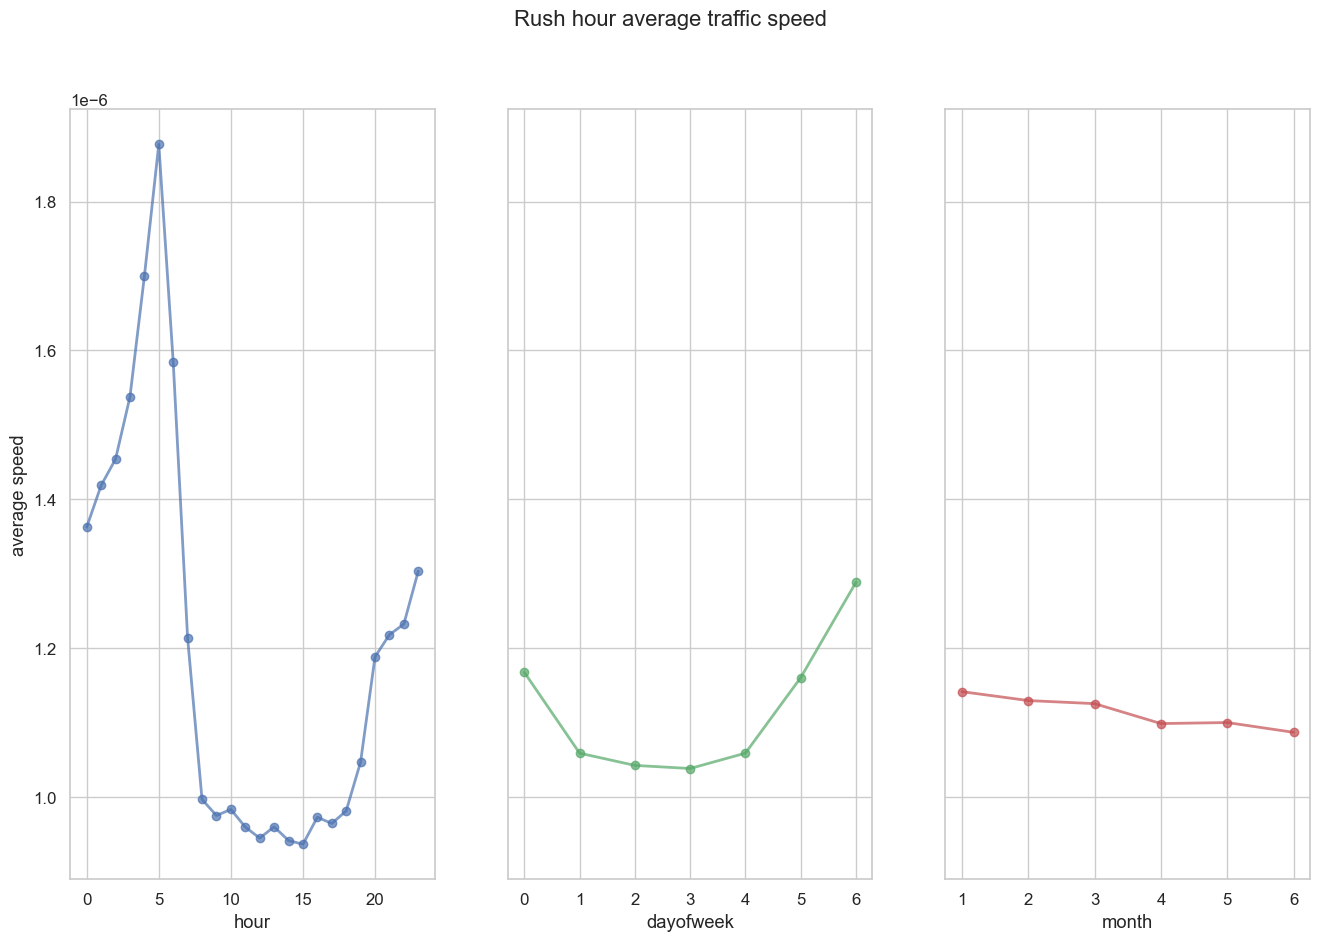

In [165]:
df.loc[:, 'avg_speed_h'] = df['distance_haversine'] / df['trip_duration'] /(60*60)

fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('hour')['avg_speed_h'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek')['avg_speed_h'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('month')['avg_speed_h'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('dayofweek')
ax[2].set_xlabel('month')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

### Step 7: Extract Other Features

### Feature: High Traffic Hour

Created a binary feature `high_traffic_hour` to indicate whether a trip occurred during hours with high trip volume. Hours with more than 45,000 trips were considered high traffic, which may reflect rush hours or peak usage times.


In [166]:
high_traffic_hours = [h for h, count in df['hour'].value_counts().items() if count > 45000]

df['high_traffic_hour'] = df['hour'].isin(high_traffic_hours).astype(int)


In [167]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,dayofweek,month,hour,dayofmonth,avg_speed_h,high_traffic_hour
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,...,3.171850,9.261031,58,76,2,6,7,8,7.379940e-07,1
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,...,2.725608,-145.332373,86,72,6,4,12,3,6.580607e-07,1
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,...,1.799289,70.081271,50,61,6,6,2,5,6.355283e-07,0
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,...,2.056152,-2.289677,75,72,3,5,17,5,6.339420e-07,1
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,...,29.190178,-53.020809,4,67,3,5,17,12,1.165344e-06,1


### Feature: Trip Type (Same vs. Different Cluster)

Added a categorical feature `trip_type` to indicate whether the pickup and dropoff locations belong to the same cluster.  
- `'same'` indicates short, local trips within the same region.  
- `'different'` indicates longer trips across different regions.


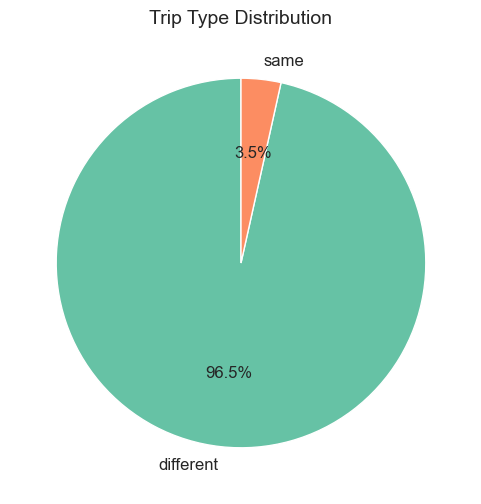

In [168]:
df['trip_type'] = (df['pickup_cluster'] == df['dropoff_cluster']).map({True: 'same', False: 'different'})
trip_counts = df['trip_type'].value_counts()
colors = ['#66c2a5', '#fc8d62']  # ألوان متناسقة

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(trip_counts, labels=trip_counts.index, autopct='%1.1f%%',
       startangle=90, colors=colors, textprops={'fontsize': 12})
ax.set_title('Trip Type Distribution', fontsize=14)
plt.show()


### Feature: Pickup Cluster + Hour Combination

Created a new feature `pickup_cluster_hour` by combining the pickup location cluster and the hour of the day.  
This captures location-time interactions, which can help the model learn patterns like specific areas being busy at certain hours (e.g., airports in the morning, downtown at rush hour).


In [169]:
df['pickup_cluster_hour'] = df['pickup_cluster'].astype(str) + "_" + df['hour'].astype(str)

df['dropoff_cluster_hour'] = df['dropoff_cluster'].astype(str) + "_" + df['hour'].astype(str)

C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\87976383.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_combinations.values, y=top_combinations.index, palette='viridis')


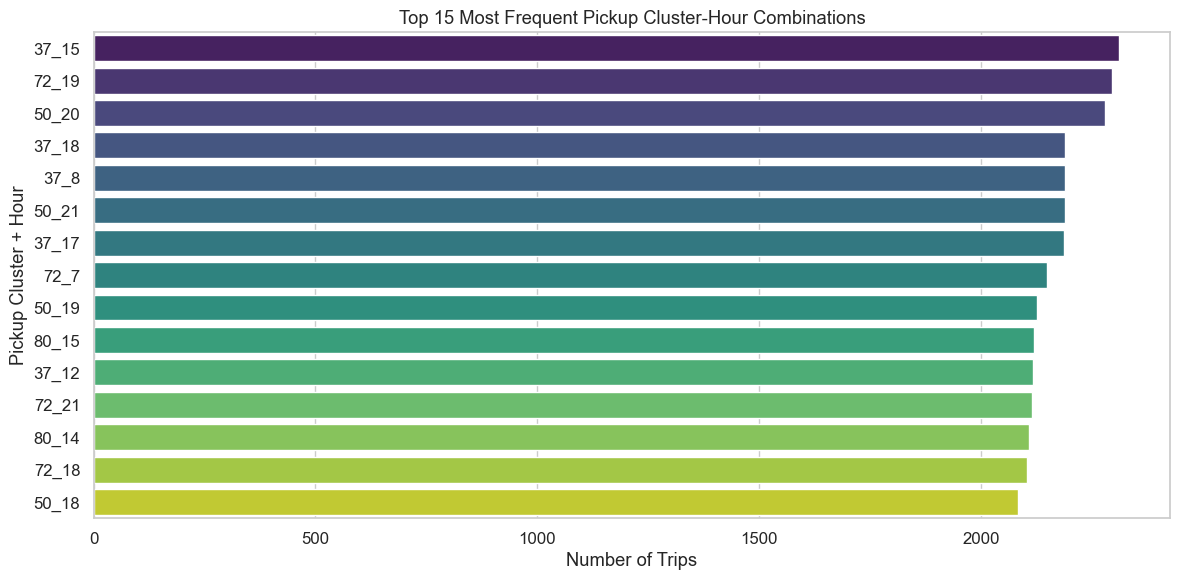

In [170]:
top_combinations = df['pickup_cluster_hour'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_combinations.values, y=top_combinations.index, palette='viridis')
plt.title('Top 15 Most Frequent Pickup Cluster-Hour Combinations')
plt.xlabel('Number of Trips')
plt.ylabel('Pickup Cluster + Hour')
plt.tight_layout()
plt.show()


### Feature: Distance to City Center

Computed the Haversine distance between the trip’s midpoint and the city center (defined as Times Square: 40.758, -73.985).  
This feature `distance_to_center` helps capture whether a trip occurred in central urban areas, which typically have different traffic dynamics than peripheral zones.


In [171]:
ablg=train['pickup_longitude']+train['dropoff_longitude']
ablt=train['pickup_latitude']+train['dropoff_latitude']
train['midpoint_latitude']=np.abs(ablt/2)
train['midpoint_longitude']=np.abs(ablg/2)

In [172]:
city_center = (40.758, -73.985)

train['distance_to_center'] = train.apply(
    lambda row: haversine((row['midpoint_latitude'], row['midpoint_longitude']), city_center),
    axis=1
)


### Feature: Day Part

Created a categorical feature `day_part` to represent the general time of day based on the hour:
- `'night'`: 00:00–05:59
- `'morning'`: 06:00–11:59
- `'afternoon'`: 12:00–17:59
- `'evening'`: 18:00–23:59

This helps model time-dependent patterns in trip duration and traffic conditions.


In [173]:
def get_day_part(hour):
    if hour < 6:
        return 'night'
    elif hour < 12:
        return 'morning'
    elif hour < 18:
        return 'afternoon'
    else:
        return 'evening'

df['day_part'] = df['hour'].apply(get_day_part)


C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\2401203965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='day_part', order=['night', 'morning', 'afternoon', 'evening'], palette='pastel')


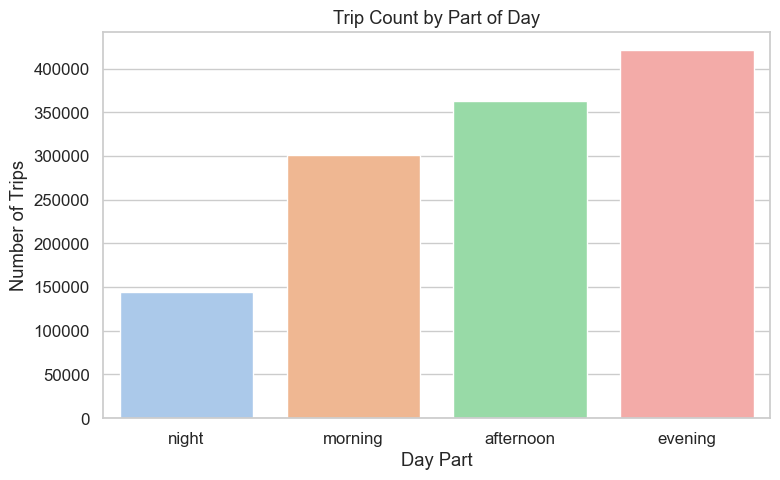

In [174]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='day_part', order=['night', 'morning', 'afternoon', 'evening'], palette='pastel')
plt.title('Trip Count by Part of Day')
plt.xlabel('Day Part')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()


### Feature: Distance-Hour Interaction

Created a numeric feature `distance_hour_interaction` by multiplying the Haversine distance of each trip by the hour of day.  
This interaction captures the intuition that the impact of trip distance on duration may vary depending on the time of day (e.g., same distance could take longer during rush hours).


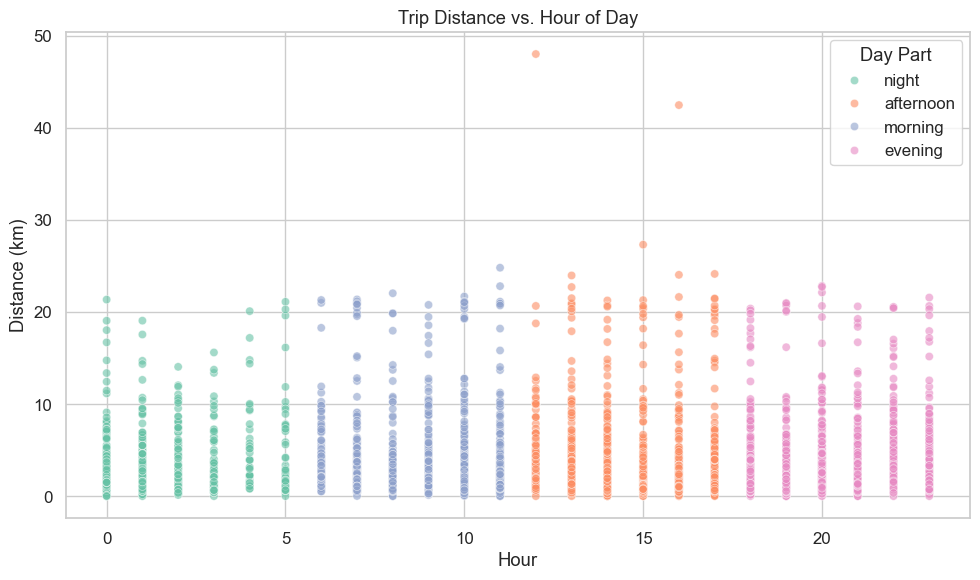

In [175]:
df['distance_hour_interaction'] = df['distance_haversine'] * df['hour']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(5000), x='hour', y='distance_haversine', hue='day_part', alpha=0.6, palette='Set2')
plt.title('Trip Distance vs. Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Distance (km)')
plt.legend(title='Day Part')
plt.tight_layout()
plt.show()


### Feature: Season

Created a categorical feature `season` to classify each trip into one of the four seasons based on the month:
- `'winter'`: December to February
- `'spring'`: March to May
- `'summer'`: June to August
- `'fall'`: September to November

This feature helps capture potential seasonal effects on trip behavior and traffic conditions.


In [176]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['season'] = df['month'].apply(get_season)

C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\4017599876.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='season', order=['winter', 'spring', 'summer', 'fall'], palette='coolwarm')


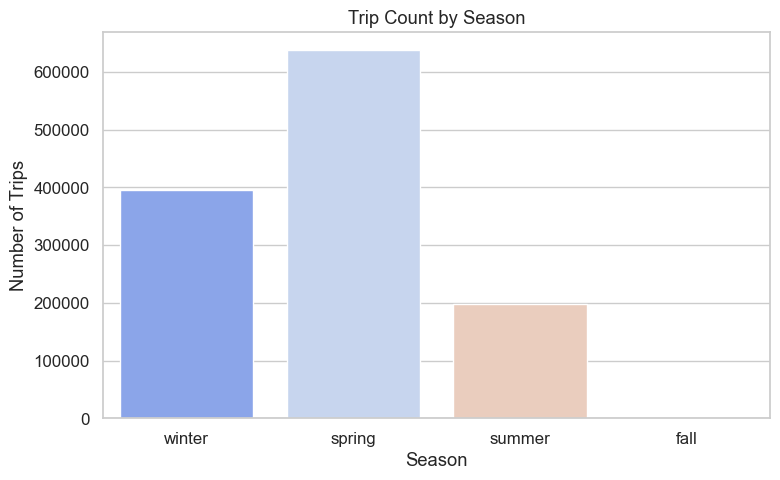

In [177]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='season', order=['winter', 'spring', 'summer', 'fall'], palette='coolwarm')
plt.title('Trip Count by Season')
plt.xlabel('Season')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()


### Feature: Pickup-Dropoff Pair

Created a categorical feature `pickup_dropoff_pair` by combining the pickup and dropoff cluster IDs.  
This feature captures route-specific behavior, allowing the model to distinguish between frequently traveled paths and less common ones.


In [178]:
df['pickup_dropoff_pair'] = df['pickup_cluster'].astype(str) + "_" + df['dropoff_cluster'].astype(str)

C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\1439616167.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pairs.values, y=top_pairs.index, palette='mako')


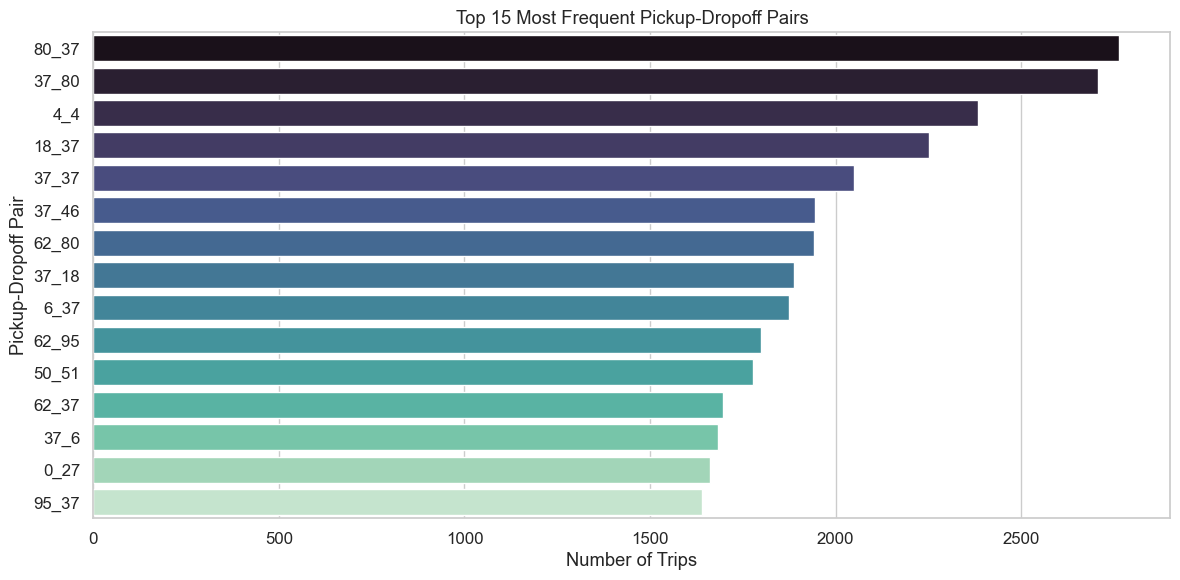

In [179]:
top_pairs = df['pickup_dropoff_pair'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_pairs.values, y=top_pairs.index, palette='mako')
plt.title('Top 15 Most Frequent Pickup-Dropoff Pairs')
plt.xlabel('Number of Trips')
plt.ylabel('Pickup-Dropoff Pair')
plt.tight_layout()
plt.show()


### Feature: Direction Bucket

Created a categorical feature `direction_bucket` by discretizing the trip’s directional bearing into compass buckets:
- `'N'`, `'NE'`, `'E'`, `'SE'`, `'S'`, `'SW'`, `'W'`

This helps the model better understand the general heading of trips, which may relate to traffic patterns, road layout, or urban density in different directions.


In [180]:
def direction_bucket(angle):
    if angle < 45 or angle >= 315:
        return 'N'
    elif angle < 90:
        return 'NE'
    elif angle < 135:
        return 'E'
    elif angle < 180:
        return 'SE'
    elif angle < 225:
        return 'S'
    elif angle < 270:
        return 'SW'
    else:
        return 'W'

df['direction_bucket'] = df['direction'].apply(direction_bucket)

C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\3691450913.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='direction_bucket', order=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W'], palette='Spectral')


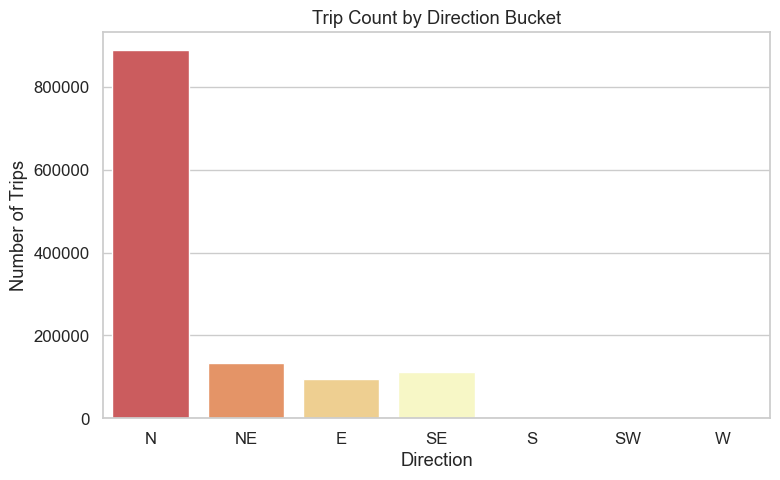

In [181]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='direction_bucket', order=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W'], palette='Spectral')
plt.title('Trip Count by Direction Bucket')
plt.xlabel('Direction')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229319 entries, 0 to 1229318
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   id                         1229319 non-null  object        
 1   vendor_id                  1229319 non-null  int64         
 2   pickup_datetime            1229319 non-null  datetime64[ns]
 3   passenger_count            1229319 non-null  int64         
 4   pickup_longitude           1229319 non-null  float64       
 5   pickup_latitude            1229319 non-null  float64       
 6   dropoff_longitude          1229319 non-null  float64       
 7   dropoff_latitude           1229319 non-null  float64       
 8   store_and_fwd_flag         1229319 non-null  object        
 9   trip_duration              1229319 non-null  int64         
 10  trip_Log_Transformed       1229319 non-null  float64       
 11  distance_haversine         1229319 no

In [183]:
df.drop(["id","pickup_datetime"],axis=1,inplace=True)


 ### Encoding Cluster-Based Trip Duration Averages
In this step, we introduce two new features that capture the average trip duration associated with each pickup and dropoff cluster. The main idea is to leverage historical trip data to inform the model about expected trip duration patterns based on spatial clusters.

🚀 Key Actions:
We temporarily merge the target (trip_duration) with train to calculate statistics.

We compute the mean trip duration (in log scale) for each pickup and dropoff cluster.

We map these means back as features into the training, validation, and test sets.

For clusters that don’t appear in the training data (unseen in test/val), we fill missing values with the global average of trip duration.

📈 Why this helps:
This adds valuable location-based historical performance to each trip, allowing the model to understand which areas tend to have longer or shorter rides.

Especially useful for tree-based models or regularized regressions (like Ridge), as it introduces target-based encoding without leakage.



In [184]:

df_temp = df.copy()

pickup_avg_duration = df_temp.groupby('pickup_cluster')['trip_Log_Transformed'].mean().to_dict()
dropoff_avg_duration = df_temp.groupby('dropoff_cluster')['trip_Log_Transformed'].mean().to_dict()


df['avg_duration_by_pickup_cluster'] = df['pickup_cluster'].map(pickup_avg_duration)

df['avg_duration_by_dropoff_cluster'] = df['dropoff_cluster'].map(dropoff_avg_duration)


C:\Users\Matrix Store\AppData\Local\Temp\ipykernel_13176\2125570146.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


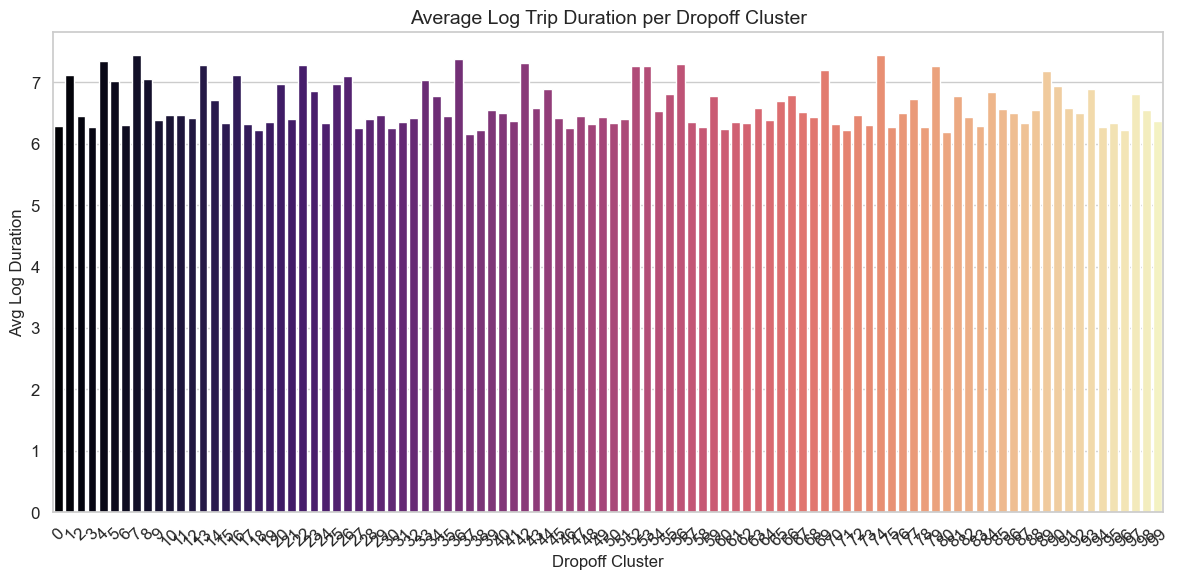

In [185]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=sorted(dropoff_avg_duration.keys()),
    y=[dropoff_avg_duration[k] for k in sorted(dropoff_avg_duration.keys())],
    palette='magma'
)
plt.title('Average Log Trip Duration per Dropoff Cluster', fontsize=14)
plt.xlabel('Dropoff Cluster', fontsize=12)
plt.ylabel('Avg Log Duration', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feature: Is Weekend
Created a binary categorical feature is_weekend by identifying trips that occurred on a Saturday or Sunday.

This feature is derived from the dayofweek column, where the integer representation assigns 5 to Saturday and 6 to Sunday.
A value of 1 in is_weekend indicates the trip took place during the weekend, while 0 signifies a weekday trip.
This helps the model differentiate between weekday and weekend travel patterns, which may exhibit variations in traffic congestion, demand, and consequently, trip durations.

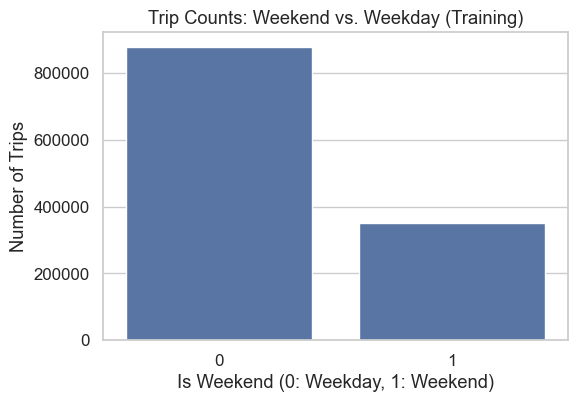

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the is_weekend feature (as before)
df['is_weekend'] = df['dayofweek'].apply(lambda x: int(x in [5, 6]))

# Visualization: Bar Chart of Trip Counts by is_weekend (Training Data)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['is_weekend'])
plt.title('Trip Counts: Weekend vs. Weekday (Training)')
plt.xlabel('Is Weekend (0: Weekday, 1: Weekend)')
plt.ylabel('Number of Trips')
plt.show()

### Feature: Is Group Ride
Created a binary categorical feature is_group_ride by categorizing trips based on the number of passengers:

1: Indicates a group ride with more than two passengers.
0: Indicates a ride with two or fewer passengers.
This helps the model better understand the occupancy level of trips, which may relate to different demand patterns, vehicle types, or trip purposes.

In [187]:
df['is_group_ride'] = df['passenger_count'].apply(lambda x: int(x > 2))

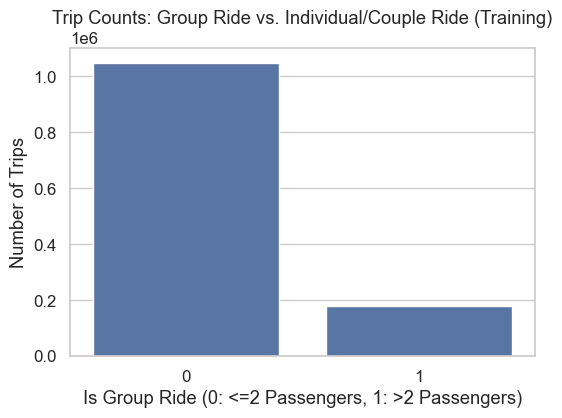

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the is_group_ride feature
df['is_group_ride'] = df['passenger_count'].apply(lambda x: int(x > 2))


# Visualization: Bar Chart of Trip Counts by is_group_ride (Training Data)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['is_group_ride'])
plt.title('Trip Counts: Group Ride vs. Individual/Couple Ride (Training)')
plt.xlabel('Is Group Ride (0: <=2 Passengers, 1: >2 Passengers)')
plt.ylabel('Number of Trips')
plt.show()

### Feature: Trip Distance Category
Created a categorical feature trip_distance_category by binning the trip distance into three categories:

0: Short trips, less than 2 units of distance.
1: Medium trips, between 2 and 5 units of distance (inclusive).
2: Long trips, greater than 5 units of distance.
This feature is derived from the distance_haversine column and helps the model understand trip distance in a more generalized way, potentially capturing non-linear relationships between distance and trip duration.

In [189]:
def categorize_distance(d):
    if d < 2:
        return 0
    elif d <= 5:
        return 1
    else:
        return 2

df['trip_distance_category'] = df['distance_haversine'].apply(categorize_distance)


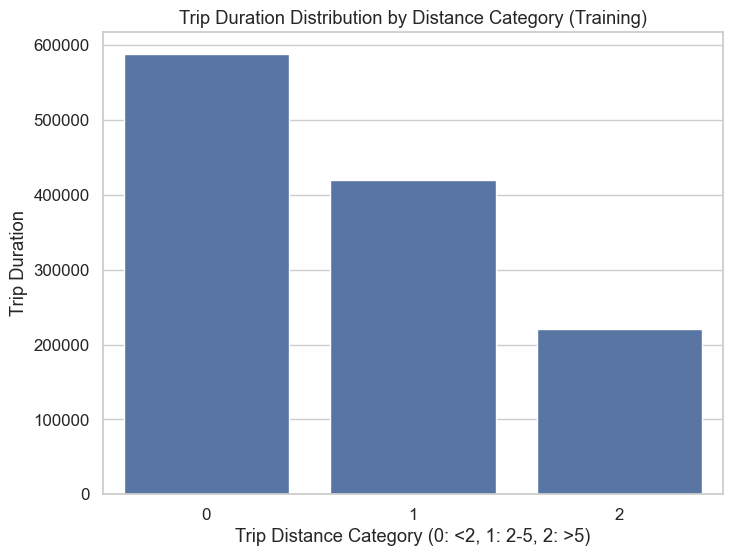

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns


# Visualization: Box Plot of Trip Duration by trip_distance_category (Training Data)
plt.figure(figsize=(8, 6))
sns.countplot(x=df['trip_distance_category'])  # Use y_train
plt.title('Trip Duration Distribution by Distance Category (Training)')
plt.xlabel('Trip Distance Category (0: <2, 1: 2-5, 2: >5)')
plt.ylabel('Trip Duration')
plt.show()

# categorical_features.append('trip_distance_category')

## Step 8: Cyclical Time Encoding
Created sine and cosine transformations for the hour, dayofweek, and month features.
This encoding preserves the cyclical nature of time-related variables (e.g., hour 23 is close to hour 0), allowing the model to better capture temporal patterns and periodic trends in the data.



In [191]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

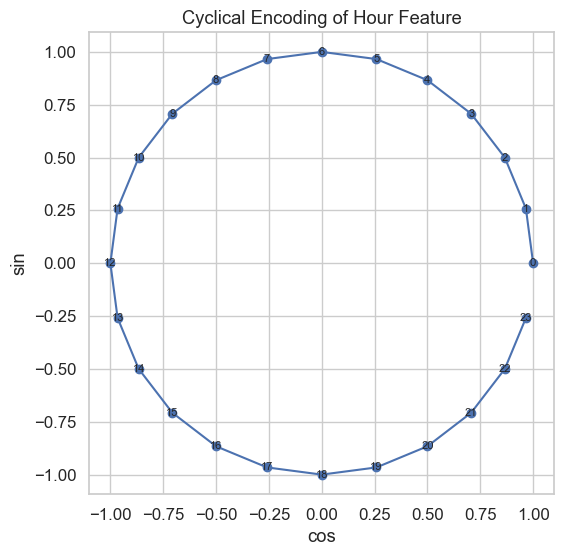

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Hour values from 0 to 23
hours = np.arange(0, 24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

plt.figure(figsize=(6, 6))
plt.plot(hour_cos, hour_sin, marker='o')
for i, (x, y) in enumerate(zip(hour_cos, hour_sin)):
    plt.text(x, y, str(i), ha='center', va='center', fontsize=8)

plt.title("Cyclical Encoding of Hour Feature")
plt.xlabel("cos")
plt.ylabel("sin")
plt.grid(True)
plt.axis('equal')
plt.show()


### Step 9: Correlation Analysis
To better understand relationships between features and the target variable, we visualized the Pearson correlation matrix. Key insights from the heatmap are summarized below:

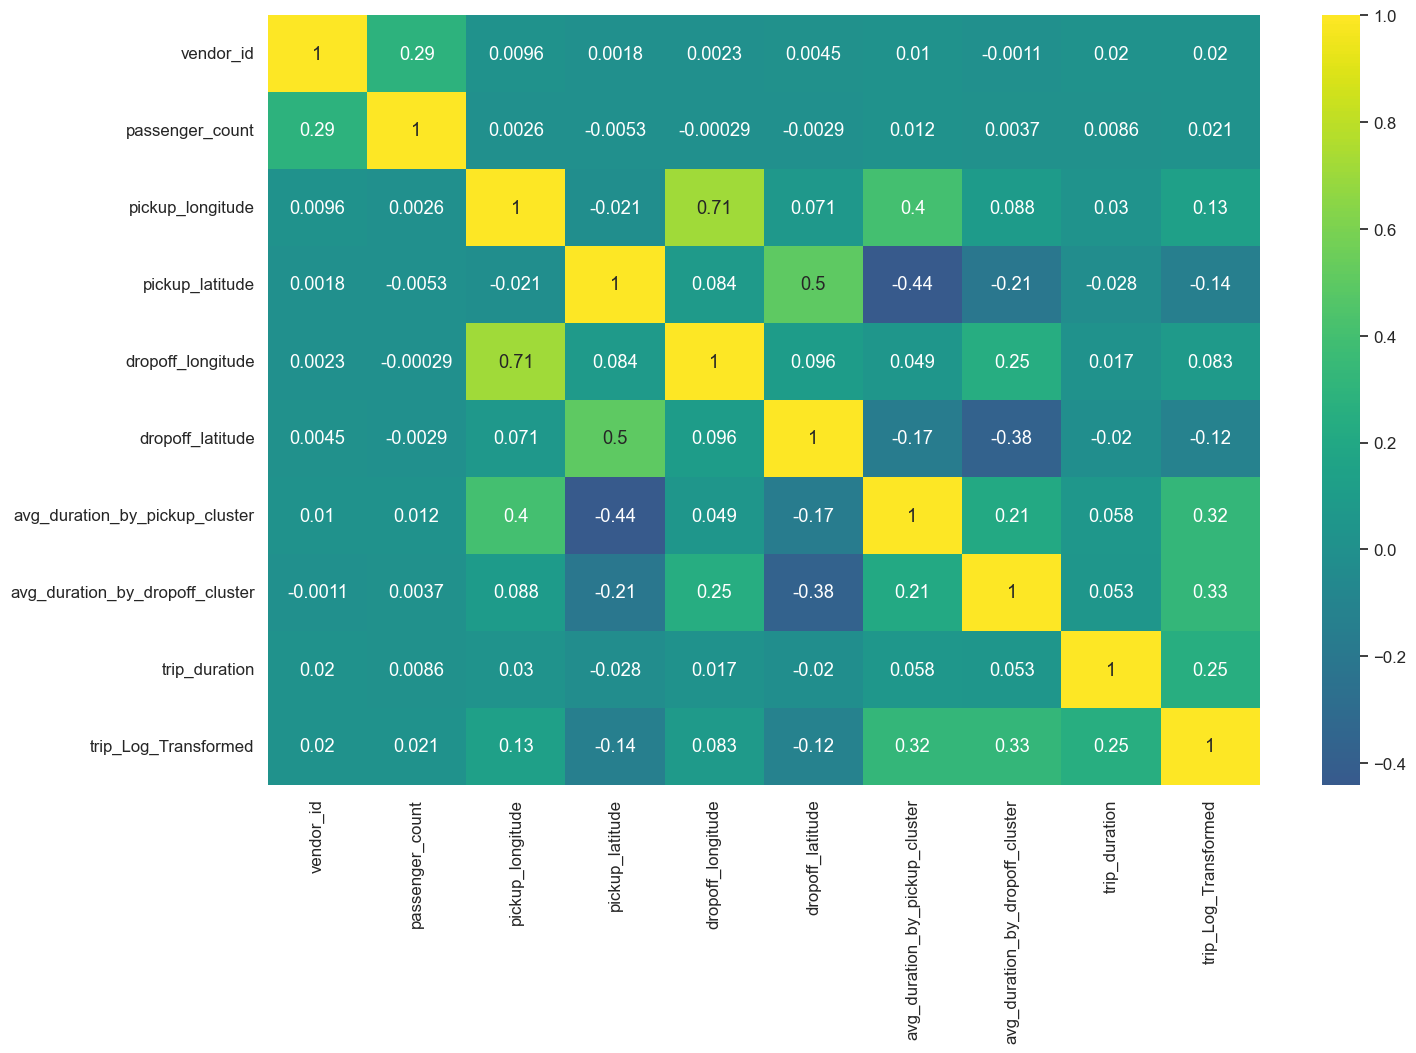

In [193]:
correlation_matrix = df[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','avg_duration_by_pickup_cluster','avg_duration_by_dropoff_cluster','trip_duration','trip_Log_Transformed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.show()


- There posstive relation trip duration (in Seconds log-Transformed) with:
   - pickup longitude ,dropoff longitude and passenger count.
   - avg_duration_by_pickup_cluster and avg_duration_by_dropoff_cluster.

- There negative relation trip duration (in Seconds log-Transformed) with:
   - pickup latitude and dropoff latitude.

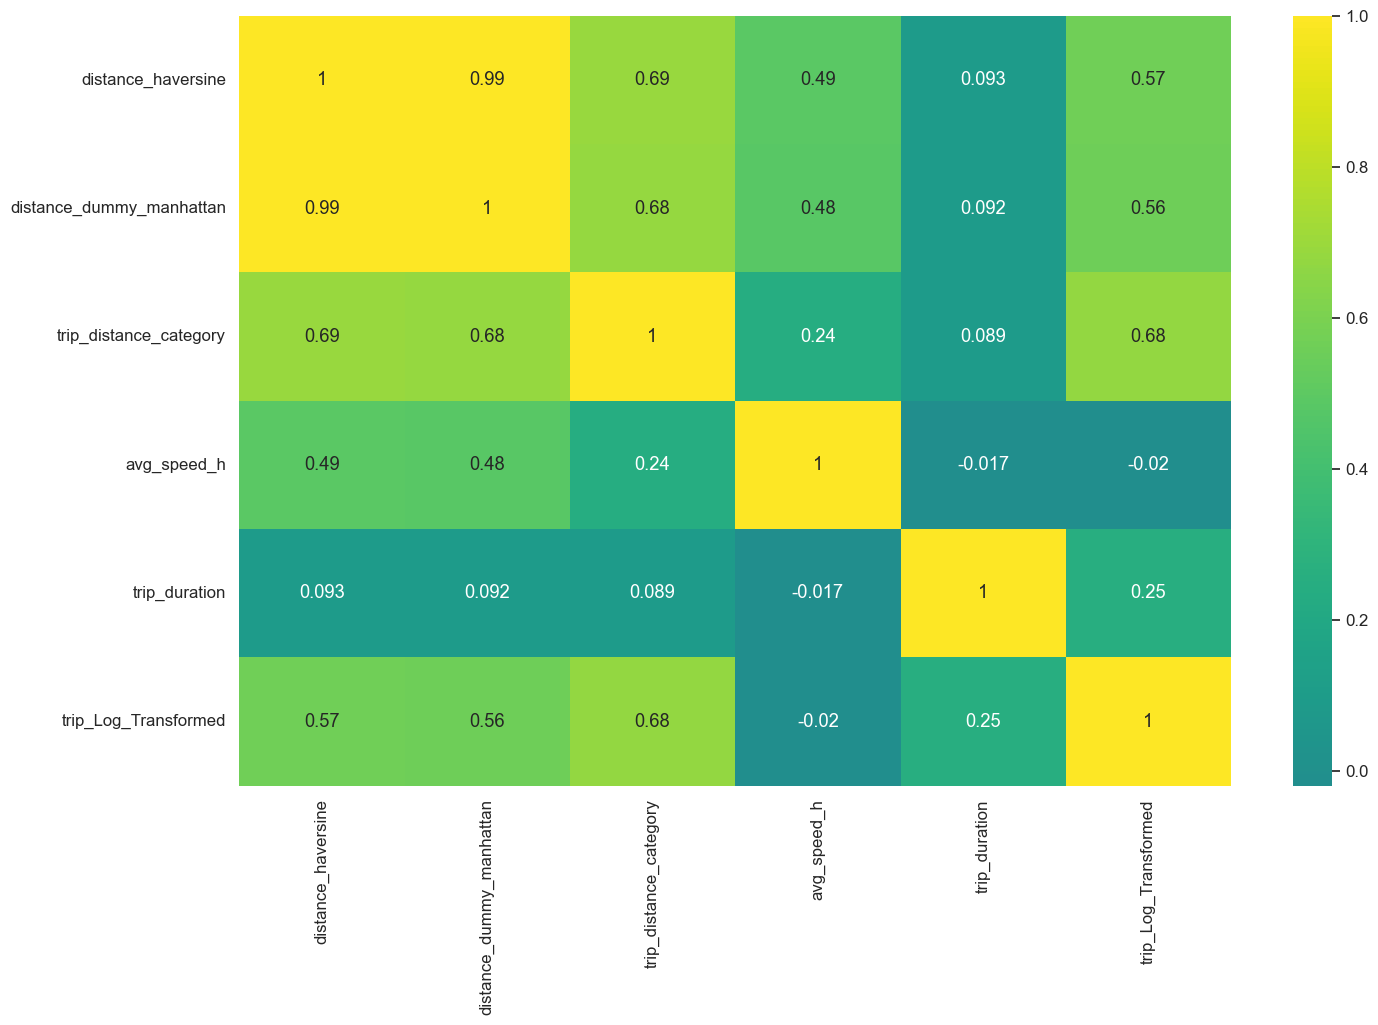

In [194]:
correlation_matrix = df[['distance_haversine','distance_dummy_manhattan','trip_distance_category','avg_speed_h','trip_duration','trip_Log_Transformed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.show()



- There posstive relation trip duration (in Seconds log-Transformed) with:
   - distance_haversine ,distance_dummy_manhattan and trip_distance_category.

- There negative relation trip duration (in Seconds log-Transformed) with:
   - Speed.

- Correlation Summary : 
    - Distance features (e.g., trip_distance_category, distance_haversine) show strong positive correlation with trip_Log_Transformed, indicating they are good predictors.

    - Cluster-based durations have moderate correlation with the target, adding useful context.

    - Features like vendor_id and passenger_count show negligible correlation and may have limited predictive value.
